In [1]:

import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14

sys.path.append('/usr/local/lib/python3.6/site-packages')
sys.path.append('/home/ychwang/jklib')


bases = ['A','T','C','G']
dna_dict = dict(zip(list('ATCG'),range(4)))
watsoncrick = {'N':'N','.':'.','C':'G','G':'C','A':'T','T':'A','*':'*'}




def add_base(li):
		"""Used in make_mer_list to add one more base to list"""
		new_li = []
		for s in li:
			for b in bases:
				new_li.append(s+b)
		return new_li

def make_mer_list(mer_len):
	"""Makes a list of all n-mers"""
	li = bases
	for i in range(mer_len-1):
		li = add_base(li)
	return li

def reverse_complement(seq):
    outseq = ''
    for s in seq:
        outseq = watsoncrick[s] + outseq
    return outseq

def hamdist(str1, str2):
   diffs = 0
   for ch1, ch2 in zip(str1, str2):
       if ch1 != ch2:
           diffs += 1
   return diffs
        
def get_snp_pos(ref,mut):
    for p in range(len(ref)):
        if(ref[p]!=mut[p]):
            break
    return p

def make_mer_matrix_no_pos(seqs,mer_len):
    mer_dict = dict(zip(make_mer_list(mer_len),range(4**mer_len)))
    rows,cols = [],[]
    r = 0
    for i in xrange(len(seqs)):
        cur_seq = seqs[i]
        for b in range(len(cur_seq)-mer_len+1):
            rows.append(r)
            cols.append(mer_dict[cur_seq[b:b+mer_len]])
        if(r%10000)==0:
            print(r)
        r+=1
    vals = np.ones_like(cols)
    rows.append(r-1)
    cols.append(4**mer_len-1)
    vals = np.append(vals,0)
    X = scipy.sparse.csr_matrix((vals,(rows,cols)),dtype=np.float64)
    return X

def find_seq_diff_pos(wt_seq,mut_seq):
    """ Function to find the actual position of mutations based
    on the WT and MUT seq"""
    muts = np.zeros(len(wt_seq))
    for i in range(len(wt_seq)):
        muts[i] = (wt_seq[i]!=mut_seq[i])
    return find(muts)[0]

def get_snp_pos(ref,mut):
    for p in range(len(ref)):
        if(ref[p]!=mut[p]):
            break
    return p

logit = lambda x: log(x)-log(1-x)
log2it = lambda x: log2(x)-log2(1-x)
expit = lambda x: 1./(1.+exp(-x))

def get_accuracy(predictions,data):
    accuracy = {'Correct':sum(sign(predictions)==sign(data)),
                'Incorrect':sum(sign(predictions)!=sign(data)),
                'Total':len(predictions),
                'Total_with_Change':sum(abs(data)>0),
                'R2':scipy.stats.pearsonr(predictions,data)[0]**2,
                'R2_P_value':scipy.stats.pearsonr(predictions,data)[1]}
    return accuracy

df =pd.read_excel('snp_data/real_n11_data.xlsx')

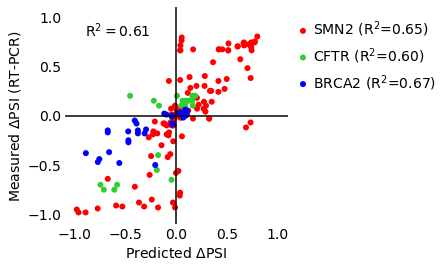

In [2]:
fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
colors = ['r','limegreen','b']
i=0
for gene in df.Gene.unique():
    cur_df = df[df.Gene==gene]
    r2 = scipy.stats.pearsonr(cur_df.HAL_DPSI_PRED,cur_df.DPSI)[0]**2
    ax.scatter(cur_df.HAL_DPSI_PRED,cur_df.DPSI,label=gene+' ($R^2$=%0.2f)' %r2,c=colors[i],edgecolor='None')
    i+=1
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
leg = ax.legend(scatterpoints=1,bbox_to_anchor=(1.72,1),fontsize=fsize,handletextpad=-0.3)
leg.get_frame().set_alpha(0)
ax.axis([-1.1,1.1,-1.1,1.1])
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Predicted $\Delta PSI$',fontsize=fsize)
ax.set_ylabel('Measured $\Delta PSI$ (RT-PCR)',fontsize=fsize)

r2 = scipy.stats.pearsonr(df.HAL_DPSI_PRED,
                           df.DPSI)[0]**2

ax.text(-0.9,0.8,'$R^2=%0.2f$'%r2,fontsize=fsize)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)


In [3]:
from keras.models import load_model
from pkg_resources import resource_filename
from utils2 import one_hot_encode
import numpy as np

# paths = ('snp_data/spliceai{}.h5'.format(x) for x in range(1,6)); context=5000; model_num=5
paths = ('SpliceAI400_g1.h5'.format(x) for x in range(1,2)); context=200; model_num=1
models = [load_model(resource_filename('spliceai', x)) for x in paths]

# paths = ('models/spliceai{}.h5'.format(x) for x in range(1, 6))
# models = [load_model(resource_filename('spliceai', x)) for x in paths]


In [4]:
BRCA2_seq = 'ATAGAAATGGATAAGGGAGTCATCCATTCTGCAAATACTTAGTGCTTACTTGTGTCTGGCAACCTGCTCGGCATTAAGGATACAAATATGAATAAGATGTCCTTTGACCTCTAAGTACTCAGTCTCGTAAGCACGTCTTGTAAGCACATCTTGGTTGCTTCCATAAAAATAAATACACTAGTGTGATATGTTATAAGAGCATGTACCAAGTGCATGAAAAGTGAGCAGCCATCTCTGGTTGGTCAGAAAAAGCTCCATAAAGCAGTTTTTGCTGAATCTTGAAAGATATACCTAAGGTCAAATGGTTAATTCTTTAATCATAACCTGCTAGAATTGATCTATAACCAAGGAAGGATAGTAAGGAATTAATAAGGCCACTCTCAACTCACTGCAAAGGAGTTAACTTTTTGAAGGCTGTAATACATAAATCTGCTGACTAGTCTCTTGAGACCTTTTGCTTTTACGTTTACTTTAGATTCAGTATTGAAAAGTAAGAGTAATGGACTTAAGCTGTGTTTTTCAACCTGTTTTGTTCAGTTCTAACATGTAATATTTTTTAAAAAATTATTCCTAAAGTTCTATGAGGAATTGTGCTGTTTCTGCCTCTCAGCAGTCCTTCCTTTTGCATTAAATCATAGGCATTTCTGTTACCATTCTTCAGCTTATTAATGAGATCCTCAGGTTATTTGGGAAATGTTTATTTGGTAATTAACTCTTTTTCACCTAGTTCATTTTTTTAACTTTTTTTTTTAAATAGCCGAGTTTCTTTTCATTGCTGAACTAAAATGGATGTGTTATTATTAGCTGAACTCCTTAGTTTACTTTAGAGTTCACCCTTTGTATGGTTCTATGGATTTTGACAAATTGTATAATGTCGTATATCTGCCATTATGGCATTATACAGAATAATTTTGCTGCCCTAAAAATCTCCCGAGTTCCACCTGCTCACCCATCCCTCCTCCTGAGCCCCTGGCAGCCACTGATCTTTTTACTGTCTGTATAGTTTTGCCTTTTCCAGAATGTCATGTAGTTGGAATCATACAGAATATAGCATTTTCAGACTGGCTTCTTTCACTTAGCAATATGCCGAGACCAGCTCGATTGTAGAGACCCTAACCCAGCGGCACTAGAGGAATTAAAGGCACACAGAAATATAGCGGTGTGGAGTGGGAAATCAGGGGTCTCACAGCCTTTTGACAGCAAGCCAGTGATAAGCATTGTTTCTATAGATTATAGATTAACTGAAAGTATTCCTTAGGGGAAATAAAGGGCTGGGCCGAAGTAAAGGGATGGGTCTGGCTAGTTATCTGCAGCAGGAGAATGTCCTTAAGGCACAGGTCGCTCATGATAGTTTGTGGTTTAAGAACGCCTTTAAGCGGTTTTCTGCCCCGGGTGGGCCAGGTGTTCCTTGCCCTCATTCCGGTAAACCCACAAGCTTCCAGCGTGGGTGTCATGGCCATCACGAACATGTCACAGTGCTGCAGAGATTTTGTTTATGGCCAGTTTTGGGGCCAGTTCCCAACAGCAATATGTGTTTAAGGTTCTTCCATGTCTTTTAATGATTTCATGCTGAATAATATTCCATCGTATTGATGTACCACAGCTTGTTTATCCATTCATCTATTGAAGGACATCTTGATTGCTTCCAAATTTTGGCAATTATGAATAAAGCTGGTATAAATATTCACATACAGGTTTGTGTGTGAATATATTTTCAACTCATTTTGGTTCACACCAAAGAGCACGATTGTGGGATCATATAGTAAGAGTATGTTTAGTTTTATGAGAAACTACAAGCTTTCTTCCAAAGTAGCTGTTGCATTTTGTATTCCCACCAGCAGTGAATGAGAGTTCTTGTTGCTCACATCCTCACCAGCATTTGGTGTGTCAGTGTTTTGAATTCTAGCCATTCTAACAAGTGTGTAGTGGTACCTCATTGTTTGTTTTATTTAATTTTTTTTTTTTTTTTTTGGAGATGAAATCTCGCTTTGTCGCCCAGGCTGGAGTGCAGTGGCGTGATCTTGGCTCACTGCAAGCTCCGCCTCCCAGGTTCACGCCATTCTCCTGCCTTAGCCTCCTGAGTAGCTGGGACTACAGGCACCCGCCACCACACCTGGCTGATTTTTTTGTATTTTTAGTAGAGACGGGGTTTCACTGTGTTAGCCAGGATGGTCTTGATCTCCTGACCTCGTGATCCGCTCGCCTCGGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCATCATGCCCGGCCTGTTTTATTTTTTAAAGTCAATTTTCTTTCAAGAATTAGCTACTTTTTAGTATCTTTAATTAAAAATCTCATTAGAGAAGGAGGTTGGATATTTTGTTGAAGTGGGGTTTTTAAGTTACACATCCATTTGCTTTATTAGTGATTATGTCTAGTCCATGTTAACTTGAAAAATGAGACTATAATGAGACATTTTATTTAGGCTGCTACAAACAGTTTTAAATTTGGTCTTCACTTTATTTTAGTAACATTGATAGAGCTTATTTTTCCCAAAAGCTAAGTTAGAGATTATAGGACCAACCGAAGCAACTATTTTCTAAGAGTAATAATAAGTGACTCAGGTGCCAAATTTGTAGTTACCATCAACTATTGGAACCATATGAGTACTTAATGCCCTGGAGAGTCAAATATAATCTACTCTAATACAGAAAATAGAAATATTGAAAAACTGTAAATTGGATTTCATATTGTTAAAGCCACCTATAGCTTTAGAAACTCTGAACATTATTTTCTTAGAAAATGGATGTGTTCAATAAGAATAGAAATTATGTATTACTGTCTGCAACTCACTTTGTCTAATTATATCCAATTTATTCATCCAGTCAATATTTCAGGAGTGACTAATATACCAGACATTTTTGTAGTTGCTAGGGATACAGTGACAAATAAGACAAAATCTCTACCTCAGATTGCTCACAGCCTAGTAGGGGGAAAAAGAACAGTGTATGATCAAACTCTTCAGGGAACACATAGGGGGGCAAACACTTAATCTTACCTTAGGGATCACTACAGTTTTCTGGAGGAGGTAGTTTCTAAATGGAAGCCTGAAAGAGTTGTTCCAGGTCAAGAAAAGCAAAGAAGGGGAAACAGCTTGTACAAAGTCCTAGAGGTTAAAGAAAACATTCTTTCAGGATATGCAAATGGTTGGGTATGGGTAAAAAGTAGACTGTAAAAGAATGGCATCATAAAAATTAAGTAAATTGTCACATAAATATATATATTTCTTATGTACCCACAAAAATTAAAAATGAAGAAATTAAGTAAATTGTGAAAGGCCTTCATACTATGGAGTTTGACTTGATCTTGAAAAGTAAGATCTTGAAAGGTTTTTAGCACAAGTGATATTGTCAGATCTGGTACATTGGTAGGTTTTCAGTAAATGTCTTCCCTTACTCCTTTTTTCTCTTTCCTTCTGCTTTTGTTTAAAGCGACAAGATGTTGCTCTTTTCCCAGGCTGGAATACAGTGGCATGATCATAGCTCAAGCTCCTGGGCTCAAGTGATCCTCCCGCCTCAGCCTCTCAAGTAGCTAGGACTACAGGCATATCACCACACCAGCGTTTTCTTTGTAGAGGCAGAGTCTCACTCTGTTGCTCAGGCAGGTGTTGAACTCCTGCCTCAAGCAATCCTCCCACCTCAGCCTCCCAGAGCCCTCAAATTATAAGCCACTGTGCTCGGGGCATCCTTTTTGGGGGGTAATCAGCAAACTGAAAAACCTCTTCTTACAACTCCCTATACATTCTCATTCCCAGTATAGAGGAGACTTTTTGTTTTTAAACACTTCCAAAGAATGCAAATTTATAATCCAGAGTATATACATTCTCACTGAATTATTGTACTGTTTCAGGAAGGAATGTTCCCAATAGTAGACATAAAAGTCTTCGCACAGTGAAAACTAAAATGGATCAAGCAGATGATGTTTCCTGTCCACTTCTAAATTCTTGTCTTAGTGAAAGGTATGATGAAGCTATTATATTAAAATATTTAAATGAAACATTTTCCTACATATATTTGTTCTATAAAGATGAATCTGATTTTTATGCTAATATTTTGGCTAAGAGCCTGGTAGAAGATCTTACATTTTTAAATAATCTTTTAGGTTGAGTCCTTTAATAGAATAGTTTTTACATTAGAAACATGTAAGTTGTTGTTCTTGTGATGTTGAATTGGCTGGTTTTCTGTATATTCTGTGATTTTTTAAGTAACAAAAATAACAGTGGTGAAAAGCAGTAAGTCAGTCCTTGAATTATCAATTTAAAATAAATTGTGTACTTTTCATCTTTGGAGAGAATATGATTTACTTTACAAATTTTTTTTTTGTTTTTTTTTTTTTTGAGATGGAGTCTCTGTCACCCAGGCTGTAGTGCAGTGGTGCGATCTCAGCTCACTGCAAGCTCCGCCTCCCGGGTTCACGCCATTCTCCTGCCTCAGCCTCCCAAGTAGCTGGGACTACAGGCGCCCGCCACCATGCCCGGCTAATTTTTTGTATTTTTAGTAGAGACGGGGTTTCACCGTGTTAGCTAGGATGGTCTCGATTTCCTGACCTCGTGATCCGCCCGCCTCAGCCTCCCAGACTGCTGGGATTACAGGCGTGAACCACTGTGCCCGGCCTACTTTACAAAATTTTTGAGTTTAAAATACACGGTTTCCAGCAGCTGAAATTTGTGAGTACATATGTGTTGGCATTTTAAACATCACTTGATGATTATTTAATGCTTCATGAGAGATTTACTTTTTAAAATGTAATATAAAATATCTAAAAGTAGTATTCCAACAATTTATATGAATGAGAATCTTCTTTTAAAAATAAGATAAACTAGTTTTTGCCAGTTTTTTAAAATAACCTAAGGGATTTGCTTTGTTTTATTTTAGTCCTGTTGTTCTACAATGTACACATGTAACACCACAAAGAGATAAGTCAGGTATGATTAAAAACAATGCTTTTTATTCTTAGAATACTAGAAATGTTAATAAAAATAAAACTTAACAATTTTCCCCTTTTTTTACCCCCAGTGGTATGTGGGAGTTTGTTTCATACACCAAAGTTTGTGAAGGTAAATATTCTACCTGGTTTATTTTTATGACTTAGTAATTGAGAATTTGACAATAGCGTTATACCTTTGCCCTGAGATTTACAAATCTGTACCTAGCATTCTGCCTCATACAGGCAATTCAGTAAACGTTAAGTGAAATAAAGAGTGAATGAAAAAATAATATCCTTAATGATCAGGGCATTTCTATAAAAAATAAACTATTTTCTTTCCTCCCAGGGTCGTCAGACACCAAAACATATTTCTGAAAGTCTAGGAGCTGAGGTGGATCCTGATATGTCTTGGTCAAGTTCTTTAGCTACACCACCCACCCTTAGTTCTACTGTGCTCATAGGTAATAATAGCAAATGTGTATTTACAAGAAAGAGCAGATGAGGTTGATAATTGTCATCTCTAATACTTCTGTTAAAAGGAAATATGAAAAGAAAATATTAGATAATGTCTTTGATAAGTGTGTTAGTAACTGACAATAATTTTATTCTATTAAGTGTAGATTGGAATAAATACAAATACATTTAGTGGTAGTCCAGTGGTGTCAAGCATTATGTTTTAGTACGATGTGATTAACGTAGAATAGCTTACAAATATTCCTTTACTGGCCTATATAAGCGTTTAAGAGGCAGTATTTGGTGTGACTGAATTCTTTTTACAAATGATTGTGGTAATTGGGGCATTAAAGCAGCATTAAATAAGCTTTTGTTTTCTCTACTTAAATGTGTTCTAAGGTCTGTATTGCCAGTAGTACTGAATTGAGGTCTTAAATTCCACAAGTGTAATTACACAACTATGTGATAAACTGCAATATTTATCCATTCATTAAACTGTAAACTCTTTGCAGTCTCACCACAGTTTCTCTTACTAGGATCTAGAAATATTTCCTATTGTAGGCTGGTTGCAGTGGCTCACGCCTGTAATCCCAACACTTTGGGAGGCTGAGAAGGGTGGATCACGTGAGGCCAGGAGTTTGAGAGCAGCCTGTACAACGTGGTGAAACCCTGTCTCTACTAAAAATAAAAAAATTGGCCAGGTGTGGTAACACACACCTGTAATCCCAGCTACCTGGGGGCTGAGGCATGGGAATTGCTTGAACCTGGGAGGCAGAGGGTGCAGTGAGCCGAGATTGTGCCACTGCACTCCAGCCTGGGTGACAGGGAGGCTGAGGTGGGAGGATCACGAGGTCAGGAGATCGAGACCATCCTGGCTAACGTGGTGAAACCCTGTCTCTATTAAAATAGAAAAAATTAGCTGGGCGTGGTGGCAGACACCTGTAGTCCCAGCTACTCAGGAGGCTGAGGCAGGAGAATGGCATGAACCCGGGAGGCGGATCTTGTAGTGATCTGAGATCATCACGCCACTGCACTCCAGCCTGGGCAACAGAGCAAGACTCTGTCTCAAAAAAAAAAAAAAATCCTGTTATAAAACTACTTAAAAATCTCTGAGTAGCTGAGATTTGGCTAATCATGACTTAGTATTTGAAAAGTTGTGACTATTTTTTTTTTTTTTAATTGAGACAAGGTTCTTCTCTGTTGCCCAGGCTGGAGTGCAGTGGCACCGTCGCAGTTCACTGCAGCCTCAACCTCCCAGGCTCAATTAATCTTTCTTCCTCTTAGCCTTCCAAGTATCTGGGACTACAGGTACCATGCCACCAGTATACTACCAGTCCTGGCTAATTTTTTTTGTATTTTTTGTAGAGATGGGTCCCGCCATGTTGCCCACACTTGTCTCAAATTCCTGAGCTCAAGCAGCCACCACACCCACCTGTGACCATTCTTTTTTATTTTTATGAGATAATAAACATACAAGTTTAAAGAAATGTCTGTACATAAATGTGATTATAGTACAAACAAGTATTTGGAAGTTCATCTAAACAAATGCATCACAGTTTATAGGCAAAACATGAAAGATTGGATAATAATGGGAAAAAAAGTAAATATTCACCAACATTCTTTCTCTTTTTTCTTTTTCGTTTTTTTTTTTTTTGAGGCGGAGTCTTGCCCTTTTGCCCAGGCTGGAGTACAGTGGCACCATCTCGGCTCACAGCAACCTCTGCCTTCTGGGTTCAGGCGATTCTCCTGCCTTAGACTCCCGAGTAGCTGGGATTACAGGCACCCACCACCACGCCTGACTAATTTTTGTATTTTTAGTGGAGAGGAGGTTTCACTGGGTTGGCCAGGGTGGTCTTGAACTCCTGACCTCAAGTGATTCGTTTGTCTCAGCCACATTTTTTTTGTCTAAGAAGATACTGGGCCAGATCATTGTTTCTCAAATTGCAGATTATGACCTGTTCATAGTTGTGAAACTTATTTTGTGAGTCGTATATGCTCTTTTTAAATGAAATGAAAATTCTGAGTACATCACATGTAGTTAGGGTTTAGAAAATAAAAAATACAATATATCTAGTTAAATTTGGACTTCAGGTAAACAGCGAATAATTTTGAGATATACTTAACACTAAAAAATTATTCATTGTTTATCTGAAATTCAAATTTAATGAGGTGTCCTGTATTTTATCCAGAAGTCCTACACACAGTAAAGTTTGTTTTGTAAAACTTTTTTACTTAACCTTTGTGTGCCCATGTGTGTGTGCAGTCATAAAGTGTGTGTGTGTGTGTGTATTTAAAAAACTAGGTTGTACTCAAAGCCTGAGCTTAATTTATTCCCAAACCAGTATTACATTTTGTTTATTCTAGCAAAATAGCATTCTGTTTTGATTCCTCTTTAGCTGGGAGTAAGTTAACCCTATTCTGTTGCTTAGATGAAATAATATGGATAAAATCATTTTGAAAATATGTATTTAATATATAGTATGCCTTTAGGCTGTAGTGTTGTCTAAATGAATGCTAAAGTCTCCAAGCTTTAGCTTTTAAGTCATAACCTCACAGCATCATCTGACTTTCCAACTCATTGTGGACAGTATTACCATAAAGTAATGATCACCAAGCCATATCTTACCACCTTGTGAGTAGTACTAAGGAAGTAAGTATAGTTTATTCACTGTGTTGATTGACCTTTCTAATTACTATACTTAAGTACTTGAATCAATTCATTTTGTTTCAAATGTGTCATGTAATCAAATAGTAGATGTGCTTTTTGATGTCTGACAAAAAATAAGTTTTTGCATTCTAGTGATAATATACAATACACATAAATTTTTATCTTACAGTCAGAAATGAAGAAGCATCTGAAACTGTATTTCCTCATGATACTACTGCTGTAAGTAAATATGACATTGATTAGACTGTTGAAATTGCTAACAATTTTGGAATGCCTTGTTAAATTATTTATCTTACATTTTTAATTTCCTAATCTGTAATTTATCTAAGCCTTTGAGAAAGTCTCTAAACCTGGTCCTATATGTGATTTTAACTTCCTGTGAAACTCTGCTGTCTCTCTGTTAAAGTTGCATATATACAATATATACCGTAGTCCCCTATTCATGGGGTATACATTCCAATATCCCCCAGTGAATGCTTGAAACCTTAGATAGTACCGAACCCTATATATATATATTAAAAATGTGTAGTATTTATATATATATACCTATAATCTTTTTTTCTATAAGCACATACCCTGTGATAAAGTTTAATTCATAAATTAGGCACAGTAAGAGATTAACAAGAACTAATAATAAAATAGGACAATTATAACAAAATACCGTAATAAAAGTTATGTGAATGTTGTCTCTCTGTCTCAAAATATCTTATTGTTCTGTACTCATGTGGCAGCAGCTTCATCAGCAGATGTGGCCTCTCCAGTAATTTTTATATTTTTCAGTCCAAACCTATTCTTGAATCTGTGTAACCAACCATCCCTTACTTGCAGTAAATGGCTTGGTGTCATTCATTTCAGGGGATCCCTTACTGAAGTTTTCGTTTAGGCTCTATGCTTTCTGGCGTAATATGTAGCTGTCAATCAAAACAACCTGTTCATGTTTTCTACCCACAAATGTAATACCTTTTCTACTTCTATGGTGCACTGTGTGGCCACAACATTTGCAGTTTGAGGTGTGACAGCAAAACCAGCTCATATGTCTTTCTCCTTCACAATCTCACAGATAGATTTGTTCTTACCATAGATGTCGCAGTACAATTTTTTTCCTTTCCTTAAGTCGAGAACTTTCACTGTTTCAATTAAAGGAAGCACTTTATGGCTTCTTTTTGGCATATTTGAATTGCCAGCATCATTATACTTGTGCTTTGGGGCCATTGTTAAGTAAAATAAGGGTGACTTGAACACAAGCACTGTGGTACCACAATAGCCGATCTGATAACCAAGACAACTACTAAGTGACTAATAGGTGGGTACCATATACAGCCTGGATACGCTGGACAAAGGGATGATTCATGTCCCAAGTGGGATGGAGCAAGATGGTGCAAGTTTTTTTTTCTCCATTTCCATTTTCCTTTCCTAAGATTTCCACATCCTAGTGGTGCAAGATTTCATCACACTACTCAGGATGACACACAATTTAAAACTTACTAATTGCTTACTTCTGGAATTTTCCATTAAAAATTTTTGGACCTAGGTTGATTGCAGATAACTGAAATCACCAAAAGTGAAACCATGGATAAGGGGGGACTACTACTATATGTGCATTGAGAGTTTTTATACTAGTGATTTTAAACTATAATTTTTGCAGAATGTGAAAAGCTATTTTTCCAATCATGATGAAAGTCTGAAGAAAAATGATAGATTTATCGCTTCTGTGACAGACAGTGAAAACACAAATCAAAGAGAAGCTGCAAGTCATGGTAAGTCCTCTGTTTAGTTGAACTACAGGTTTTTTTGTTGTTGTTGTTTTGATTTTTTTTTTTTGAGGTGGAGTCTTGCTCTGTCACCCGTGATCTCGGTTTACCGCAACCTCTGCCTCCCGTGCTCAAGCGATCCTGCCTCAGCTTGCCAAGTAGCTGAGATTACAAGCATGCACCACCATGCCCAACTATTGTATTTTTAGTAGAGATGGCATTTCACCATGTTGGCCAGGCTGGTCTCAAATGGTCGTGAGCCACCATGCCCAGCCTGAACTACTCTTTTTAATTGGCACCATTGAAGGATTGCTCCTCTTTTCTTAAAGAGAAAATATATTACCTTTCCTTTCTTGACTACTGAAGTAGTATTTTATCTCAAAGTATTGAGAGTAGAAACTAACTTGGTGTGCCTGTGATCCCAGCTACTCAGGAGGCTGAGGTGGGAGGATCGCTTAAGCCCAGGCGGTCAAGGTTGCAGTGAGCTGTGTGTGTGCCACTGCACTCCCACCTGGGCAACAGAGTGAGACCGTGTCTCAATGGAAAAAAAGAGAAACTAATTTGATTTCGATGACAGTATTTAAATACTGTGTAAGACAGTACTATTTAATATGTGGTTGTGACACAAAAACAAAGCCTATTGAAAATTTTCAGAGACAATAAGATATATAATTAACAAAATCTGAGCTTTTTTTTTTTCTAATTAGAAAGTAAATGTGGTTTAGATATACCATAGTTTACCTAATCAGGTCATGGAATATTGCATTTTTCTTAGTATGTGTGTATGTCTGTATAACTGTGTAGGATTTGATATCTGTTTTTGTCTGTGTGGTATCATGTACGTATGTATATGCATATGTAAAATCAGATTTACCCTTGTTATAGGGCCACAGAA'
SMN2_seq=  'TAGCTGGGACTACAGGTGCCTGCCACCACGCCTGTCTAATTTTTTGTATTTTTTTGTAAAGACAGGGTTTCACTGTGTTAGCCAGGATGGTCTCAATCTCCTGACCCCGTGATCCACCCGCCTCGGCCTTCCAAGAGAAATGAAATTTTTTTAATGCACAAAGATCTGGGGTAATGTGTACCACATTGAACCTTGGGGAGTATGGCTTCAAACTTGTCACTTTATACGTTAGTCTCCTACGGACATGTTCTATTGTATTTTAGTCAGAACATTTAAAATTATTTTATTTTATTTTATTTTTTTTTTTTTTTTGAGACGGAGTCTCGCTCTGTCACCCAGGCTGGAGTACAGTGGCGCAGTCTCGGCTCACTGCAAGCTCCGCCTCCCGGGTTCACGCCATTCTCCTGCCTCAGCCTCTCCGAGTAGCTGGGACTACAGGCGCCCGCCACCACGCCCGGCTAATTTTTTTTTATTTTTAGTAGAGACGGGGTTTCACCGTGGTCTCGATCTCCTGACCTCGTGATCCACCCGCCTCGGCCTCCCAAAGTGCTGGGATTACAAGCGTGAGCCACCGCGCCCGGCCTAAAATTATTTTTAAAAGTAAGCTCTTGTGCCCTGCTAAAATTATGATGTGATATTGTAGGCACTTGTATTTTTAGTAAATTAATATAGAAGAAACAACTGACTTAAAGGTGTATGTTTTTAAATGTATCATCTGTGTGTGCCCCCATTAATATTCTTATTTAAAAGTTAAGGCCAGACATGGTGGCTTACAACTGTAATCCCAACAGTTTGTGAGGCCGAGGCAGGCAGATCACTTGAGGTCAGGAGTTTGAGACCAGCCTGGCCAACATGATGAAACCTTGTCTCTACTAAAAATACCAAAAAAAATTTAGCCAGGCATGGTGGCACATGCCTGTAATCCGAGCTACTTGGGAGGCTGTGGCAGGAAAATTGCTTTAATCTGGGAGGCAGAGGTTGCAGTGAGTTGAGATTGTGCCACTGCACTCCACCCTTGGTGACAGAGTGAGATTCCATCTCAAAAAAAGAAAAAGGCCTGGCACGGTGGCTCACACCTATAATCCCAGTACTTTGGGAGGTAGAGGCAGGTGGATCACTTGAGGTTAGGAGTTCAGGACCAGCCTGGCCAACATGGTGACTACTCCATTTCTACTAAATACACAAAACTTAGCCCAGTGGCGGGCAGTTGTAATCCCAGCTACTTGAGAGGTTGAGGCAGGAGAATCACTTGAACCTGGGAGGCAGAGGTTGCAGTGAGCCGAGATCACACCGCTGCACTCTAGCCTGGCCAACAGAGTGAGAATTTGCGGAGGGAAAAAAAAGTCACGCTTCAGTTGTTGTAGTATAACCTTGGTATATTGTATGTATCATGAATTCCTCATTTTAATGACCAAAAAGTAATAAATCAACAGCTTGTAATTTGTTTTGAGATCAGTTATCTGACTGTAACACTGTAGGCTTTTGTGTTTTTTAAATTATGAAATATTTGAAAAAAATACATAATGTATATATAAAGTATTGGTATAATTTATGTTCTAAATAACTTTCTTGAGAAATAATTCACATGGTGTGCAGTTTACCTTTGAAAGTATACAAGTTGGCTGGGCACAATGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCAGGGCAGGTGGATCACGAGGTCAGGAGATCGAGACCATCCTGGCTAACATGGTGAAACCCCGTCTCTACTAAAAGTACAAAAACAAATTAGCCGGGCATGTTGGCGGGCACCTTTTGTCCCAGCTGCTCGGGAGGCTGAGGCAGGAGAGTGGCGTGAACCCAGGAGGTGGAGCTTGCAGTGAGCCGAGATTGTGCCAGTGCACTCCAGCCTGGGCGACAGAGCGAGACTCTGTCTCAAAAAATAAAATAAAAAAGAAAGTATACAAGTCAGTGGTTTTGGTTTTCAGTTATGCAACCATCACTACAATTTAAGAACATTTTCATCACCCCAAAAAGAAACCCTGTTACCTTCATTTTCCCCAGCCCTAGGCAGTCAGTACACTTTCTGTCTCTATGAATTTGTCTATTTTAGATATTATATATAAACGGAATTATACGATATGTGGTCTTTTGTGTCTGGCTTCTTTCACTTAGCATGCTATTTTCAAGATTCATCCATGCTGTAGAATGCACCAGTACTGCATTCCTTCTTATTGCTGAATATTCTGTTGTTTGGTTATATCACATTTTATCCATTCATCAGTTCATGGACATTTAGGTTGTTTTTATTTTTGGGCTATAATGAATAATGTTGCTATGAACATTCGTTTGTGTTCTTTTTGTTTTTTTGGTTTTTTGGGTTTTTTTTGTTTTGTTTTTGTTTTTGAGACAGTCTTGCTCTGTCTCCTAAGCTGGAGTGCAGTGGCATGATCTTGGCTTACTGCAAGCTCTGCCTCCCGGGTTCACACCATTCTCCTGCCTCAGCCCGACAAGTAGCTGGGACTACAGGCGTGTGCCACCATGCACGGCTAATTTTTTGTATTTTTAGTAGAGATGGGGTTTCACCGTGTTAGCCAGGATGGTCTCGATCTCCTGACCTCGTGATCTGCCTGCCTAGGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACTGCACCTGGCCTTAAGTGTTTTTAATACGTCATTGCCTTAAGCTAACAATTCTTAACCTTTGTTCTACTGAAGCCACGTGGTTGAGATAGGCTCTGAGTCTAGCTTTTAACCTCTATCTTTTTGTCTTAGAAATCTAAGCAGAATGCAAATGACTAAGAATAATGTTGTTGAAATAACATAAAATAGGTTATAACTTTGATACTCATTAGTAACAAATCTTTCAATACATCTTACGGTCTGTTAGGTGTAGATTAGTAATGAAGTGGGAAGCCACTGCAAGCTAGTATACATGTAGGGAAAGATAGAAAGCATTGAAGCCAGAAGAGAGACAGAGGACATTTGGGCTAGATCTGACAAGAAAAACAAATGTTTTAGTATTAATTTTTGACTTTAAATTTTTTTTTTATTTAGTGAATACTGGTGTTTAATGGTCTCATTTTAATAAGTATGACACAGGTAGTTTAAGGTCATATATTTTATTTGATGAAAATAAGGTATAGGCCGGGCACGGTGGCTCACACCTGTAATCCCAGCACTTTGGGAGGCCGAGGCAGGCGGATCACCTGAGGTCGGGAGTTAGAGACTAGCCTCAACATGGAGAAACCCCGTCTCTACTAAAAAAAATACAAAATTAGGCGGGCGTGGTGGTGCATGCCTGTAATCCCAGCTACTCAGGAGGCTGAGGCAGGAGAATTGCTTGAACCTGGGAGGTGGAGGTTGCGGTGAGCCGAGATCACCTCATTGCACTCCAGCCTGGGCAACAAGAGCAAAACTCCATCTCAAAAAAAAAAAAATAAGGTATAAGCGGGCTCAGGAACATCATTGGACATACTGAAAGAAGAAAAATCAGCTGGGCGCAGTGGCTCACGCCGGTAATCCCAACACTTTGGGAGGCCAAGGCAGGCGAATCACCTGAAGTCGGGAGTTCCAGATCAGCCTGACCAACATGGAGAAACCCTGTCTCTACTAAAAATACAAAACTAGCCGGGCATGGTGGCGCATGCCTGTAATCCCAGCTACTTGGGAGGCTGAGGCAGGAGAATTGCTTGAACCGAGAAGGCGGAGGTTGCGGTGAGCCAAGATTGCACCATTGCACTCCAGCCTGGGCAACAAGAGCGAAACTCCGTCTCAAAAAAAAAAGGAAGAAAAATATTTTTTTAAATTAATTAGTTTATTTATTTTTTAAGATGGAGTTTTGCCCTGTCACCCAGGCTGGGGTGCAATGGTGCAATCTCGGCTCACTGCAACCTCCGCCTCCTGGGTTCAAGTGATTCTCCTGCCTCAGCTTCCCGAGTAGCTGTGATTACAGCCATATGCCACCACGCCCAGCCAGTTTTGTGTTTTGTTTTGTTTTTTGTTTTTTTTTTTTGAGAGGGTGTCTTGCTCTGTCCCCCAAGCTGGAGTGCAGCGGCGCGATCTTGGCTCACTGCAAGCTCTGCCTCCCAGGTTCACACCATTCTCTTGCCTCAGCCTCCCGAGTAGCTGGGACTACAGGTGCCCGCCACCACACCCGGCTAATTTTTTTGTGTTTTTAGTAGAGATGGGGTTTCACTGTGTTAGCCAGGATGGTCTCGATCTCCTGACCTTTTGATCCACCCGCCTCAGCCTCCCCAAGTGCTGGGATTATAGGCGTGAGCCACTGTGCCCGGCCTAGTCTTGTATTTTTAGTAGAGTCGGGATTTCTCCATGTTGGTCAGGCTGTTCTCCAAATCCGACCTCAGGTGATCCGCCCGCCTTGGCCTCCAAAAGTGCAAGGCAAGGCATTACAGGCATGAGCCACTGTGACCGGCAATGTTTTTAAATTTTTTACATTTAAATTTTATTTTTTAGAGACCAGGTCTCACTCTATTGCTCAGGCTGGAGTGCAAGGGCACATTCACAGCTCACTGCAGCCTTGACCTCCAGGGCTCAAGCAGTCCTCTCACCTCAGTTTCCCGAGTAGCTGGGACTACAGTGATAATGCCACTGCACCTGGCTAATTTTTATTTTTATTTATTTATTTTTTTTTGAGACAGAGTCTTGCTCTGTCACCCAGGCTGGAGTGCAGTGGTGTAAATCTCAGCTCACTGCAGCCTCCGCCTCCTGGGTTCAAGTGATTCTCCTGCCTCAACCTCCCAAGTAGCTGGGATTAGAGGTCCCCACCACCATGCCTGGCTAATTTTTTGTACTTTCAGTAGAAACGGGGTTTTGCCATGTTGGCCAGGCTGTTCTCGAACTCCTGAGCTCAGGTGATCCAACTGTCTCGGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACTGTGCCTAGCCTGAGCCACCACGCCGGCCTAATTTTTAAATTTTTTGTAGAGACAGGGTCTCATTATGTTGCCCAGGGTGGTGTCAAGCTCCAGGTCTCAAGTGATCCCCCTACCTCCGCCTCCCAAAGTTGTGGGATTGTAGGCATGAGCCACTGCAAGAAAACCTTAACTGCAGCCTAATAATTGTTTTCTTTGGGATAACTTTTAAAGTACATTAAAAGACTATCAACTTAATTTCTGATCATATTTTGTTGAATAAAATAAGTAAAATGTCTTGTGAAACAAAATGCTTTTTAACATCCATATAAAGCTATCTATATATAGCTATCTATATCTATATAGCTATTTTTTTTAACTTCCTTTATTTTCCTTACAGGGTTTTAGACAAAATCAAAAAGAAGGAAGGTGCTCACATTCCTTAAATTAAGGAGTAAGTCTGCCAGCATTATGAAAGTGAATCTTACTTTTGTAAAACTTTATGGTTTGTGGAAAACAAATGTTTTTGAACATTTAAAAAGTTCAGATGTTAGAAAGTTGAAAGGTTAATGTAAAACAATCAATATTAAAGAATTTTGATGCCAAAACTATTAGATAAAAGGTTAATCTACATCCCTACTAGAATTCTCATACTTAACTGGTTGGTTGTGTGGAAGAAACATACTTTCACAATAAAGAGCTTTAGGATATGATGCCATTTTATATCACTAGTAGGCAGACCAGCAGACTTTTTTTTATTGTGATATGGGATAACCTAGGCATACTGCACTGTACACTCTGACATATGAAGTGCTCTAGTCAAGTTTAACTGGTGTCCACAGAGGACATGGTTTAACTGGAATTCGTCAAGCCTCTGGTTCTAATTTCTCATTTGCAGGAAATGCTGGCATAGAGCAGCACTAAATGACACCACTAAAGAAACGATCAGACAGATCTGGAATGTGAAGCGTTATAGAAGATAACTGGCCTCATTTCTTCAAAATATCAAGTGTTGGGAAAGAAAAAAGGAAGTGGAATGGGTAACTCTTCTTGATTAAAAGTTATGTAATAACCAAATGCAATGTGAAATATTTTACTGGACTCTATTTTGAAAAACCATCTGTAAAAGACTGAGGTGGGGGTGGGAGGCCAGCACGGTGGTGAGGCAGTTGAGAAAATTTGAATGTGGATTAGATTTTGAATGATATTGGATAATTATTGGTAATTTTATGAGCTGTGAGAAGGGTGTTGTAGTTTATAAAAGACTGTCTTAATTTGCATACTTAAGCATTTAGGAATGAAGTGTTAGAGTGTCTTAAAATGTTTCAAATGGTTTAACAAAATGTATGTGAGGCGTATGTGGCAAAATGTTACAGAATCTAACTGGTGGACATGGCTGTTCATTGTACTGTTTTTTTCTATCTTCTATATGTTTAAAAGTATATAATAAAAATATTTAATTTTTTTTTAAATTAGCTGTATCTGTGATTGTATTTCTTTTTTGCATATTATTTTGCCCTTTGGCCCATATTTTGATATGGATGCCACCATAGCATTTTGTGTATGTGCATGTGTATTCCCACTTAATGTCACATTTTTCATGTCTTTACATATTCTTATTTTTGTTTGTTTTTGAGACAGAGTCTCGCTCTGCTGCCCACGCTGGAGTGCAGTGGTGCAATCTCAGCTCACTGCAACCTCTGCTATCCGGGTTCAAGCAGTTCTCGTGCCTCACCCACGTGAGTAGTTGGGATTACAGGCATGTGGCACCATGCCCCACTAAGTTTTGTATTTTTAGTAGAGATGGAGTTTCACCATGTTGGCCAGGCTGGTCTCAAACTCCTGCCCTCAAGTGATTCGACCACCCTGGCCTCCCAAAGTGCTGGGATTACAGCCGTGAGCCACCGCACACGGCCTCTCTATTTATTTCTATACATAGCTTTTCACATTATATTATGTTTATATATTGTTTATATCTGTATTTCCTCTTTCATTAGAGAAAAGGTAGTACATCTTATTCTTCATGGTGTCTACAATATCTGGCAGTTTTTGGAAGTCAAGCGTGAGCTTAGAGCATAGACTGGTGGGATTGTCAAAGAAGAGGGCAACTGGAAGAGAACTGTCAGTTATTTTTGGATCAGTCTTTAATTCATCATGACGGGTTAGGCATTAGTTGTATTTCTTGCTAATTTTGAAGAAGACTTATTAACAAATCCTACATTAGGTAAATGGTTTTGAAAGTTGAGTTAATCATAATGGTGTTTGACCTAGGACTATTTTTAGGCCCTATTTATCTTAATATCGAATAATGAAGCAGCTTCCCCCTTAGATATAGACAGAAAACATCAAAGCCACCACACTACCTGGCTGGATTTATCCTAGTAATAAAATCAAAACTGAGCTAGTTCTCTGGCTTTCATTGTAATAATTGTCCTTGTGGTTGTAAGGAATCTAGATGAAAATTACATGGTCTGTTCTACAGCCACAGCTGTACCTACATTCAGAAGACAGACAAAAGTTGCTGTGTTTGAAGAGATCCTTCATTAAGGGATCAGACAGAGATTACTTTGAGACATATTCTAAGTTTAACTTTTCTGCAGGGTTGCCATTAACAGAAATAAACTACAGAGTTAATTTCTTTTTGTTTTTGATACAGTCTAACTCTCACCCAAGCTGGAGTGCAGTGGCGCAATTTCAGCTCACTGCAACCTCTGCCTCCCAGGTTCAAGCAATTCTCCTGCCTCAGCCTCCCGAGCAGCTGGGACTACAGGCATGTGCCACTATGCCTGGCTAATTTTTGTATTTTTAGTAGTAGAGACGTGGTTTCGCCACGTTGGCCAGGCTGGTCTGGAACTCCTGACCCCAGGTAATCCACCTGCCTCGGCCTCCCAAAGTGCTGGGATTACAAGCTTGAGCCACTACGCCTGACCCAGAGTTAACTTTTTAAAAAAGTTTTTATGAACTTAAGTCTTGTGATGTTTGAAATAATGGATTCAATTTAGACATCAAATTCCAGAAGTTACTAAGAGCAGCTGGGCGCGGCAGCTCACACCTGTAATCCCAGCACTTTGGGAGGCCGAGGCGGGTGGATCACCTGAGATCAGGAGTTCCAGACCAGCCTGGCCAACATAGTAAAACCCTGTCTCTACTAAAAATACAAAAATTAGCCCGGCATGGTGGCACGCCCTGTAGTCCCAGCTACTTGGGAGGCTGAGGCAGGAGAATTGCTTGAACCCGGGAGGTGGAGGTTGTGGTGAGCCGAGATTGTGCCACTGTACTCAAGCCTGGGCTAAAAAGCGAGACTCCGTCTCAAAAAAAAAAAAAAAAAAAACACGTTACTAAGAGCAACTCTGGGCCAGGCACGGTGGCTTACACCTGTAATCCCAGCATTTTGGGAGGACGAGACAGGCGGATCACTTGAGCCCAGGAGTTCAAGACCAGCATAAGCAACAACGCAAAACCCCTGACTCTACAAAACATGAAAGAATTAGCAAGGCATGGTGGTGCATGCCTGTAGTCCCAGCTACTGGAGAGGCTGAGGCAAAAGGATCACTTGAGTACAGGAGGTTGAGGCTGTGTAATGAGCCGTGTTCACACCATTGCACTTCAGCCTGGGCAACAGACTGAGACCCTGTCTCAAAAAAAAAAACCAAACCAAAGCAACAAACAAAAAACAAGAGCAACTCTGCTTCTGTACACTTTTTTTTTTTTTTTTGGTAGTGACATGATCTATGTTGCCCAAGCTGGTCTCGAGTTCCTGGGTTCAAGCCATTCTCCCACCTCGGGCTCCCAAAGTGCTAGGATTACAGGCATGAATCACCATGCCCAGCCCTTCTGTACACTTTTCACAGTGTACCCTTTTGTGTTTTTTAAAATGTTTGTGTATACATTTATTGTGAATTTTTAAAAAACATGTAATTAAGGCCAGGCATGGTGGCTCATACCTGTAATCCTAGCACTTTGAGAGGCTGAGGTGGGTGGATCACCTGAGGTCGGTAGTTCGAGACCAGCCTGGCCCAACATGGTGAAACCCCATCTCTACTAAAAATACAAAAAAAAAATTAGCTCGGCATGGTGGTGGGCGCCTGTGATCCCAGCTACTGGAGAGGCTGAAGCATGAGAATCACTTGAACCCAGGAGGCGGAGGTTGCAGTGAGCCAAGATCGTGCCACTACACTCCAGCCTGGGTGACTCAGTGACTGTCTCAAAAAGAAAAAAAGTAATTAAGTTCTGTCATGATATATCATCATTACCCTTTTTGAACTTTTAAAATTTTTTATCTTTAGAGGTAATTCATATAATGTTCTTCAATAGATAAGTGCTTTTCTGTCAATATATCTTGGAGAACACACCATATCAGTATTTAAAACTCTCATTCTTCCTATTTCTCCACATCCTCTCCAGCACCCGTTGTTTCCTGACTTTTTAATGATTGCCATTCTAACTGGTGTGAGATGGTATCTTATTGTGGTTTTGATTTGCATTTCTCTGATGGCCAGTGATGGTGAGCATTTTTTCATGTGTTTTTTAGCTGCATAAATGTCTTCTTTTGAGAAGTGTCTGTTCATGTCCTTCGCCCACTTTTTGATGGGGTTGTCTGTTTTTTTCTTGTAAATTTGTTTGAGTTCATTGTAGATTCTGGATATTAGCCCTTTGTCAGATGAGTAGATTGCAAAAATTTTCTCCCATTTTGTAGGTTGCCTGTTCACTCTGATGGTAGTTTCTTTTGCTGTGCAGAAGCTCTTTAGTTTAATTAGATCCCAGTTTTGGCTTTTGTTGCCGTTGCTTTTGGTGTTTTAGACATGAAGTCCTTGCCCATGCCTATGTCCTGAATGGTAATGCCTAGGTTTTCTTCTAGGGTTTTTATGGTTTTAGGTCTAACATTTAAGTCTTTAATCCATCTTGAATTAATTTTTGTATAAGGTGTAAGGAAGGGATCCAGTTTCAGCTTTCTACATATGGCTAGCCAGTTTCCCAGCACCATTTATTAAATAGGGAATCCTTTCCCCATTGCTTGTTTTTCTCAGGTTTGTCAAAGATCAGATAGTTGTAGATATGCGGCGTTATTTCTGAGGGCTCTGTTCTGTTCCATTGGTCTATATCTCTGTTTTGGTACCAGTACCATGCTGTTTTGGTTACTGTAGCCTTGTAGTATAGTTTGAAGTCAGGTAGCGTGATGCCTCCAGCTTTGTTCTTTTGGCTTAGGATTGACTTGGCGATGCGGGCTCTTTTTTGGTTCCATATGAACTTTAAAGTAGTTTTTTCCAATTCTGTGAAGAAAGTCATTGGTAGCTTGATGGGGATGGCATTGAATCTGTAAATTACCTTGGGCAGTATGGCCATTTTCACGATATTGATTCTTCCTACCCATGAGCATGGAATGTTCTTCCATTTGTTTGTATCCTCTTTTATTTCATTGAGCAGTGGTTTGTAGTTCTCCTTGAAGAGGTCCTTCACATCCCTTGTAAGTTGGATTCCTAGGTATTTTATTCTCTTTGAAGCAATTGTGAATGGGAGTTCACTCATGATTTGGCTCTCTGTTTGTCTGTTATTGCTGTATAAGAATGCTTGTGATTTTTGTACATTGATTTTGTATCCTGAGACTTTGCTGAAGTTGCTTATCAGCTTAAGGAGATTTTGGGCTGAGACAATGGGGTTTTCTAGATATACAATCATGTAATCTGCAAACAGGGACAATTTGGCTTCCTCTTTTCCTAATTGAATACCCGTTATTTCTTTCTCCTGCCTAATTGCCCTGGC'
CFTR_seq ='TATCTTCTATCTGTTTCTTACTGTCCCCTTCAGTATTCTTGTCCTTTTTTCCCGCTATTATCTTTTTGACCTTTTAATATATAGATATCTACTTCTACTTCTGACAATTTTTGCTTCTCCAATTTTCTTTCTTTTTCTCCTCTGCACACATTTATTTATTTTCTTCTATGTACTTCTTTATTTTTAACTTAATATTTGATTAACTTCCCTTCCCTGTCTCTTTTCCTTCTTTCCATAAATCTTCATTAATTGCCTGCACTGAGCTAGGATTCTATACTCTCTAAATCAATAATCTATTTTCTATAGTCAACTGTGTTATAATCGTACTGTCAAGATAACTACTTATTTTTAATACTTAAAAATATTTTGAAATTTTAACCAATTTAATTAATACAATGTTGAGTTCAAATTTGAAAAAAACAATGGAAAACTGTAATAATTCTAGCAACCTCCTGCTTTTTAATAATGTATTAGAAAATTTGCCTCTTTTTCAAAAGCCTACAGTGAATCTATTCATACAAGGCAAAAGCAAACCATTCTCTTCATTCTCTTTTTTTCTCCAAAAGATTTAAGTGTTTTTTGTTTGTTTGTTTTGTTTTGTTTTTTAGATATTGAGTCTTGCTCTGTCATCCAGGCTGCAGTGCAGTGGTGTGATCATAGCTCGCTATAGCCTCGAATTCCTGGGTTCAAGCAATCCTCCTCCCTCACCCTCCTGAGTAGCTGGGGCTACAGGTGCATGCTACCATGCCCAGCTAATTTAAAAGGAAAAAAATTGTGTAGAGATGGGTCTTGCTATGTTGCCCAGGCTGGTCTCAAACTTCCAATCTCAAGCATTTCTCCCACCCAGCATCCTGAAGTGCTGAGATTATAAGTGAGCCACTATGCCCAACCAGATTTAGTTTTTAAAAAGAGAATACGATTTGAAAAAGGAAAAATGTGAGGCAGGAGAGAAGAAATACACACACGAGCTGTTTTGTAATTGCTGTAAAACTGAAATCTTCAGCCTCACTAAAGGAGCACTTGCATGAACACCTCTAAATTACCTTATTACCTTCTAAATTAGGTGTGAAGTCTAACTTCTAAATTATGAGTGAAATCCACTGCAATTCTTGTTATTTGGATGGAATCCTAGGTATGTGGTCCAGTTCATGAGTTGAACAAAAGCATGCTCATTTAGGCCAGGTAGAAAGAAATAAAGACCTATGTTTTACATGTCTCATAACCACTGAAGGTCCTTCTCATAAGCAGTGCTTATGGGTATTAACGACCTCTCTATATTTTACTTCTCCAGTGCCTAAGTAGCCGAGTCCACTGAGTCCTGCTACATCTCCTCCAACATGTCAGCATTTTTTTCACAGGCCTTTTGTTACTCTAGATCAGAAATGTTGATAGCAACAGTTCCTTGAGGGCAGCAGCTAGCATGATGCCAGCCAACAGGAACCACCAAATGGTTCTTAATATAAATTACTACTTATTAATCTATTTACTTTGTGCATTTGGAGTTTTGCATGTAAAGTCCTATTTATGTCCATATGGTAGATAAATGGAACAAATGAATAACAGAAGTAACCATTTTGATACTTTAGATATAGATAATATTGGATTATTTCTGGATTGTGAAAGAAGAAGGAAGAAGCATATGGAAGAGAAGTTTTAGTAGAGGGGAGGAAGGAGGAGGTGGAAACGAATGTACAAGGATGGGAGGAGAAAAGGGAGAGAGACTTTTTTTTTTTTAAGGCGAGAGTTTACTACCTATCTAACTCTTCGCATTCTTGAAGTCTCAGACCAAATCCCATCGGTTTGAAAGCCTCTAGGGTATTCTATCTATTGTATACTTCTGTTATGTACAAAATTAATTTGCCAATTAATTGTGAACTGTTTTATAAACTATCTTAAAATGGTTAGTTAAATCTTTGGGATAGTATTTAGCTTTCTCCAGGATTATGACTTACCTTCTAAATTAGACATACAATGCCTAGGAGTCAAGGACTATTTTGCATAAATTCCAGTCTTCTTTTACAATGCCTAGAATGATTGTTACCACAGAAATATTCATTACCTGGGAGAAAGGATGACAGGAGGGGCAGAATGAATGGAGAGAGGTCGTGAGAATGAGGTGCTGAGGATGGACGAGGAAGAAAGCTGTTTTAGTTGGGAGGATAGGTGACAGAAGCATGGAAAGGAATTGCCTTGGACCCATGGAAGCCCAGTGAAGATACTTAGATCCTGCAGGGGTGTGAATAATGTTCTTTTAGTTTCTCTTCTTAGGAGGTTTGTTCATTTTGGGAGATTTCTTTTGAAAAGAGTGAACTTAAATTGGAGAAAAGTACATTTTAGTATGTTGATAACATTTGAATTTGTAAAATGGACCTATGGATGATCTACACATATTTATATACCCATAAATATACACATATTTTAATTTTTGGTATTTTATAATTATTATTTAATGATCATTCATGACATTTTAAAAATTACAGAAAAATTTACATCTAAAATTTCAGCAATGTTGTTTTTGACCAACTAAATAAATTGCATTTGAAATAATGGAGATGCAATGTTCAAAATTTCAACTGTGGTTAAAGCAATAGTGTGATATATGATTACATTAGAAGGAAGATGTGCCTTTCAAATTCAGATTGAGCATACTAAAAGTGACTCTCTAATTTTCTATTTTTGGTAATAGGACATCTCCAAGTTTGCAGAGAAAGACAATATAGTTCTTGGAGAAGGTGGAATCACACTGAGTGGAGGTCAACGAGCAAGAATTTCTTTAGCAAGGTGAATAACTAATTATTGGTCTAGCAAGCATTTGCTGTAAATGTCATTCATGTAAAAAAATTACAGACATTTCTCTATTGCTTTATATTCTGTTTCTGGAATTGAAAAAATCCTGGGGTTTTATGGCTAGTGGGTTAAGAATCACATTTAAGAACTATAAATAATGGTATAGTATCCAGATTTGGTAGAGATTATGGTTACTCAGAATCTGTGCCCGTATCTTGGTGTCAGTGTATTTGTTTGCCTCATAGTATAGTTTACTACAAATGGAAAACTCTAGGATTCTGCATAATACTGGACAGAGAAGATGTAAATATCTGTTAGTTCCATCATAGACCCTGCCACTCCAATGTACACACCAGCTTTAGGCTTCTTGGTATAGATAAACATACATTTTCAAAATTTTTCATCATAATTTTCATAACAAAATAGGAAGGCAAATGATGTCACTTGGCTTAAAATCTATAATATTTAAAATAAACAGGACAAATGCATTAACATTGTTGGGGGAGGAGGTCCCTTAGTAGAAACACTCTTGGTCCAAGCATTTTAAAGCTGTCAAAGAGATGTAAATATAGATAATGTATGTCAAGGAGAGAGCTTTGTGGTTAAACTGTAACTTTCAGTTTAAACAATTATTGGTGACTCTGATGTCAAATGTTTCTCAAGCTTTATCTGAACAAAATTCTTCTCACTTTGTTGCCAAAGTCGTTAACAAGAAATCACATTGACTCATTGATGTTTTGGCTCCTTTCCCTTACTTTCTGTTGCTTTCCAAAAGCTGAGACAGGAAACTAACCCTAACTGAGCACCTGCAATTGCCTGGTAGTATTCTAGTCATGTGTGTACTTTTGTGTGTATGTAATCCCCTTACAGCTCTGCAAAGTAAGAATTGTTCTCCCTGCTTTACAGAAGAGATCATAAGATAATTGAGGCTGTTAGATGTTAACTTGCCAAAAGCCATACAGGAAAATGGTAGAGTCACAGTTTGAACCAGGTCCTTTTGATTCTTTACATTAAACCATGCTTTGATCTTGGAAATACACTGTAAGGCAATAAATCAATAGATACGGATAATTCACAGGCTTCTAAATAAATGGAAGTTGATTGTTTTTATCTGTGAGCCAAAGTAAGACTTATTCTAAGAATTCCACAAATTTAGATAAGATAGAGTATATGGCTTCTAGACATCCAACATAGAACTGAGTTTGTGTTATCAGTTTAAGATTTGGTTTTGCTGTAAGGTGCACACACTTTGAGGAACTAAAAATAATTGTCTGTTCTTATTCTGATCAGAATGTGTAATGTGTTGTCCAGTTTTGGATGATGAATTTCTTATTTCTAATCTCATAAGAAACTTGTCATAGATGTGAGGGAGAGAATTAAGAACAGAGTGTGGGGAAGAAACTGTGTACATTTTGATGGGATCCATTATGTAGCTCTTGCATACTGTCTTCAAAAATAAGTTACACTATAAAGGTTGTTTTAGACTTTTAAAGTTTTGCCATTGGTTTTTAAAAAAATTTTTAAATTGGCTTTAAAAATTTCTTAATTGTGTGCTGAATACAATTTTCTTTATTACAGAAGTACCAACAATTACATGTATAAACAGAGAATCCTATGTACTTGAGATATAAGTAAGGTTACTATCAATCACACCTGAAAAATTTAAATGTTATGAAGAAATTATCTCATTTCTATTAATATGGGAACTGTGTCTTCATCTTTATTACTGTTCTAAGGTCAACTCAATGTAGATTTTACTTGCTTATGGTTTCATATTTTAGCTAAATAGTAAAATAATATGGATATACATTTTGTTGTGACTTACTCATACTTTCCTTATTTGGAACTTTTATGAATATGATATAGAGACTGAAACTACAAGGAACAAAATGCAATATCAATTATACAGTTGTGGCAGCACTGCTATCAATTTGTTGATAGTGGTTAACACTTAGAAAAACATTTTAAAAATAATTTCACATAAGTAATGTAATTTATTAGCTGTCTCTGACATTTTACAGTTTGGAATAGTTTATTTTCTTTTTGGTGTCCTCACCAAAACCCAACATCTTCAAGGGCAGGAACTGTATAATTTTTGCCATTGTATTTTGAGCACATAGCATGGTACTTGCCTCTAAATAGATACTATTGTTAAAATATTTTTTAAGGTAATATTTTAAAGTGTATGCTATGGTACAGTTCAGTTTGTGACTTTTGCTAGTTTATGCCACTTACAGTTAGCAAAATCACTTCAGCAGTTCTTGGAATGTTGTGAAAAGTGATAAAAATCTTCTGCAACTTATTCCTTTATTCCTCATTTAAAATAATCTACCATAGTAAAAACATGTATAAAAGTGCTACTTCTGCACCACTTTTGAGAATAGTGTTATTTCAGTGAATCGATGTGGTGACCATATTGTAATGCATGTAGTGAACTGTTTAAGGCAAATCATCTACACTAGATGACCAGGAAATAGAGAGGAAATGTAATTTAATTTCCATTTTCTTTTTAGAGCAGTATACAAAGATGCTGATTTGTATTTATTAGACTCTCCTTTTGGATACCTAGATGTTTTAACAGAAAAAGAAATATTTGAAAGGTATGTTCTTTGAATACCTTACTTATAATGCTCATGCTAAAATAAAAGAAAGACAGACTGTCCCATCATAGATTGCATTTTACCTCTTGAGAAATATGTTCACCATTGTTGGTATGGCAGAATGTAGCATGGTATTAACTCAAATCTGATCTGCCCTACTGGGCCAGGATTCAAGATTACTTCCATTAAAACCTTTTCTCACCGCCTCATGCTAAACCAGTTTCTCTCATTGCTATACTGTTATAGCAATTGCTATCTATGTAGTTTTTGCAGTATCATTGCCTTGTGATATATATTACTTTAATTATTATTATACTTAACATTTTTATTTACTTTTTGTGTTAGTATTTTATTCTGTCTTCTCCTTAGATAGTAACCTTCTTAAGAAAATATATATGCTAAGTGTTTTACTGGTTTAATATGCTTAGACTACTCATCTACCTCAATACTTCCTTGGAGATCTCCTCCTCAGTCACACAGAGCTCAGGACTTATATTTCCTTGGAACTCCTGTTAGGGTCCAATGTACATGAAATTCCCTAGACAGACAGACAGTCAGTTATATGGCTTGATTTCAAAGTTTCAAAATGATTTAATGGACTATCAAGTAGTTTATTAGGAGAACAGTTATTATACTCTTCTAAAAATAAAGACTTTAAGCAATAAAGATGTATATGTATATAAAATGGCTGGGTTATTCCTAGAAGTACCTTTCTTAGAATTTAGTTAAATTTAATATCCAAGATACTATCTTTTCAACCCTGAGATTGTGAAAAGTAACTTCTATCAATATAAACTTTACTACATTTGTATTGTGTTAGTGTGTTACAGTATAATCTAGAACAATGTGTCTTTCTATATGATATATGACATTTTAATGCCTAAAAAAACTGATATGTCTTAGATGATTCTAGTCAGGATTTACTTCTAGAATAGATTAAAATTCTATTTGAGGAGAGTCAAATTAATTATCGAATTCTCAGTTGTTATTATTGCTGTTTTATTTTTAGTGAAACAGATTAGTCTTAATGTAAACACTTGAGAAATAAATTGATGGTCAACCTAAAATGTAAAAAAGAAATTAATAGAAAATTTAAAGAGCAACAAAGCTCTGACATTTAAAAGAAATGAAGTACAAATCTCTAGGGACCTTAAAGATCATCTAATAATTTCCTCATTTTCTAGATAAATAAACTGAGAGACCCCGAGGATAAATGATTTGCTCAAAGTCAAATATCTACTTAATATAGGAAATTTAATTTCATTCTCAGTCTGTTAACATGCAACTTTTCAATATAGCATGTTATTTCATGCTATCAGAATTCACAAGGTACCAATTTAATTACTACAGAGTACTTATAGAATCATTTAAAATATAATAAAATTGTATGATAGAGATTATATGCAATAAAACATTAACAAAATGCTAAAATACGAGACATATTGCAATAAAGTATTTATAAAATTGATATTTATATGTTTTTATATCTTAAAGCTGTGTCTGTAAACTGATGGCTAACAAAACTAGGATTTTGGTCACTTCTAAAATGGAACATTTAAAGAAAGCTGACAAAATATTAATTTTGCATGAAGGTAGCAGCTATTTTTATGGGACATTTTCAGAACTCCAAAATCTACAGCCAGACTTTAGCTCAAAACTCATGGGATGTGATTCTTTCGACCAATTTAGTGCAGAAAGAAGAAATTCAATCCTAACTGAGACCTTACACCGTTTCTCATTAGAAGGAGATGCTCCTGTCTCCTGGACAGAAACAAAAAAACAATCTTTTAAACAGACTGGAGAGTTTGGGGAAAAAAGGAAGAATTCTATTCTCAATCCAATCAACTCTATACGAAAATTTTCCATTGTGCAAAAGACTCCCTTACAAATGAATGGCATCGAAGAGGATTCTGATGAGCCTTTAGAGAGAAGGCTGTCCTTAGTACCAGATTCTGAGCAGGGAGAGGCGATACTGCCTCGCATCAGCGTGATCAGCACTGGCCCCACGCTTCAGGCACGAAGGAGGCAGTCTGTCCTGAACCTGATGACACACTCAGTTAACCAAGGTCAGAACATTCACCGAAAGACAACAGCATCCACACGAAAAGTGTCACTGGCCCCTCAGGCAAACTTGACTGAACTGGATATATATTCAAGAAGGTTATCTCAAGAAACTGGCTTGGAAATAAGTGAAGAAATTAACGAAGAAGACTTAAAGGTAGGTATACATCGCTTGGGGGTATTTCACCCCACAGAATGCAATTGAGTAGAATGCAATATGTAGCATGTAACAAAATTTACTAAAATCATAGGATTAGGATAAGGTGTATCTTAAAACTCAGAAAGTATGAAGTTCATTAATTATACAAGCAACGTTAAAATGTAAAATAACAAATGATTTCTTTTTGCAATGGACATATCTCTTCCCATAAAATGGGAAAGGATTTAGTTTTTGGTCCTCTACTAAGCCAGTGATAACTGTGACTATAAGTTAGAAAGCATTTGCTTTATTACCATCTTGAACCCTCTGTGGGAAGAGGTGCAGTATAAATAACTGTATAAATAAATAGTAGCTTTCATTATTTATAGCTCGCAAAATAATCTGTATGGAAGTAGCATATATAAGGTATATAAACATTTAGCCTCTTGATAGGACTAACTCACATTCTGGTTTGTATATCAGTCTTGCCTGAATTTAGCTAGTGTGGGCTTTTTTTTATCTTGTGAGTTTGCTTTATACATTGGGTTTCTGAAAAGATTTCTTTTAGAGAATGTATATAAGCTTAACATGTACTAGTGCCAATCTTCAGACAGAAATTTTGTTCTATTAGGTTTTAAGAATAAAAGCATTTTATTTTTAAAACAGGAAATAATATAAAAAGGAGAGTTTTTGTTGTTTTAGTAGAAAACTTAATGCCTTGGATGAAATGAGCCATGGGCAGGGTTGTAATGAATTGATATGTTTAATAGTATAGATCATTTGTGAATAATATGACCTTTGACAAGACACAAGCCATTAACATCTGTAGGCAGAAGTTTCCTTCTTTGTAAAATGAGGGAATAAAATAGATCCCTAAAGTGTGTAATTTTAGTATTTCTAAACTTTATGAAGGTTTCCTAAATGATAATTCATCTATATAGTGTTTTTTTGTGTGTTTGTTTGTTTGTTTGTTTGAGATGGAGTCTCGCTCTGTCACCTAGGCTGGAGTGCAATGGTGCAACCTCGGCTCACTGCAACCTCTGCCTCCTGGGTTCAAGCTAATCTCCTGCCTCAGCCTCCTGAGTAGCTGAGATTACAGGCATGCACCACCATGCCGAGCTAATTTTTGTATTTTTAGTAGAGAAGGGGTTTCATCATGTTGACCAGGCTGGTCTTGAACTCCTGACCTTGTGATCCACCCACCTCAGCCTCCCAAAGTGCTGGTATTACAGGCGTGTGCCACCACGTCCAGCCTGAGCCACTGCGCCCAGCCCATCTATATAGTTTAATATCAATCTAAATGAATTTCTCAGTCCTGAGCCTAAAAATTTAGTTGTAAAGAATGATATCCTTGACTAATAATAGTTTCTATTAATGGATTGCATCTAGTGCTAGGTGGCATATATTTAGTCCCCACAACTACCCTGGAAGGTATTTAAAATTTTTCACATTTGCAGATAAGGAAACTAAAGTTCAGAGTTCGGCAACATGCTTGAATTCAAGCAGCTCCTAGGATGTTAATGGTGGAGGTTGGGTTCAAATCCAGATCTGTCTGACTCAAAAAATGCATACTCCTAACCAGTGCACTATATCCCAATTCCATAGGAGCCCTTCTTTGTGATTCATAGCACTTTCCCATGAGTTTTGTTGATTTTGTGAGAAACAAAACTCTTTTTCCTTTGGACTGTCTGGAATCTCTCTTTTTCAAATTTTTGAAATGTATTTCTATGCCAAAAGACAAAGATTTCTAGAGGAATATGCCTAGGATGAGAATTATGTAATTTAAATCACAGCTGGAAAGAGAGAAAGTCCTAAGTTACTAAGAAATGTTCAAACACAAATGAGCTTTCAGTCTATTGGAAGACCTTTATAGCTAGAAGTATACTGAACTGTACTTGTCCATGGACCCCTGAAGAAACAGGTTAAATCAAAGAGAGTTCTGGGAAACTTCATTTAGATGGTATCATTCATTTGATAAAAGGTATGCCACTGTTAAGCCTTTAATGGTAAAATTGTCCAATAATAATACAGTTATATAATCAGTGATACATTTTTAGAATTTTGAAAAATTACGATGTTTCTCATTTTTAATAAAGCTGTGTTGCTCCAGTAGACATTATTCTGGCTATAGAATGACATCATACATGGCATTTATAATGATTTATATTTGTTAAAATACACTTAGATTCAAGTAATACTATTCTTTTATTTTCATATATTAAAAATAAAACCACAATGGTGGCATGAAACTGTACTGTCTTATTGTAATAGCCATAATTCTTTTATTCAGGAGTGCTTTTTTGATGATATGGAGAGCATACCAGCAGTGACTACATGGAACACATACCTTCGATATATTACTGTCCACAAGAGCTTAATTTTTGTGCTAATTTGGTGCTTAGTAATTTTTCTGGCAGAGGTAAGAATGTTCTATTGTAAAGTATTACTGGATTTAAAGTTAAATTAAGATAGTTTGGGGATGTATACATATATATGCACACACATAAATATGTATATATACACATGTATACATGTATAAGTATGCATATATACACACATATATCACTATATGTATATATGTATATATTACATATATTTGTGATTTTACAGTATATAATGGTATAGATTCATATAGTTCTTAGCTTCTGAAAAATCAACAAGTAGAACCACTACTGATATTTTATTATTTCATATTACATATAAAATATATTTAAATACAAATATAAGAAGAGTTTTTAATAGATTTTTAATAATAAAGGTTAAGAGATTCGAAAGCTCAAAGTAGAAGGCTTTTATTTGGATTGAAATTAAACAATTAGAATCACTGTTGATATTTTATTATTTCATATTACATATAAAATATATTTAAATATAAAGATAAGAGTTTTTAATAGATTTTATAATAAATGTTAAGAGATTAAAAAACTGAAAATAGAAGGCTTTTATTTGGATTGAAATTAAAGGCCAGGCATGGTGGTTCATGCCTGTAATCCCAGAATTTTAGGAGACTGAGTGGGGAGGATTGCTTGAGCCCAGGGGTCAAGACCAGCCTGGGCAACACAGTGAGACACCGTATCTACAAAATAATTAAAAAATTAGC'


In [5]:
all_df =pd.read_excel('snp_data/real_n11_data.xlsx')

In [6]:
gtex_donor_dpsi=[]
gtex_acceptor_dpsi=[]
gtex_joint_dpsi=[]

for i in range(all_df.shape[0]):
    if all_df.iloc[i].Gene=='SMN2':
        donor_seq = 'AGTAAGTCTGCC'
        full_seq=SMN2_seq
        
    if all_df.iloc[i].Gene=='CFTR':
        donor_seq = 'GGTATGTTCTTTGAAT'
        full_seq=CFTR_seq
        
    if all_df.iloc[i].Gene=='BRCA2':
        donor_seq = 'GGTAATAATAGCAAAT'
        full_seq=BRCA2_seq
    
    
    
    acceptor_pos=5300
    now_pos=all_df.iloc[i].POS+5300-1

    ALT_seq = all_df.iloc[i].ALT
    REF_seq = all_df.iloc[i].REF
    if str(ALT_seq)=='nan' or ALT_seq=='':
        ALT_seq=''
    
    REF_seq = all_df.iloc[i].REF
    if str(REF_seq)=='nan' or REF_seq=='':
        REF_seq=''

    alt_full_seq=full_seq[:now_pos]+ALT_seq+full_seq[now_pos+len(REF_seq):]
    ref_full_seq=full_seq[:now_pos]+REF_seq+full_seq[now_pos+len(REF_seq):]


    len1 = len(ALT_seq)
    len2 = len(REF_seq)
        
    donor_pos_ref=ref_full_seq.find(donor_seq)
    donor_pos_alt=donor_pos_ref-len2+len1
    
##################################################
    seq_alt_for_donor = alt_full_seq[donor_pos_alt-context:donor_pos_alt+context+1]
    seq_ref_for_donor = ref_full_seq[donor_pos_ref-context:donor_pos_ref+context+1]

    
    x_alt_donor = one_hot_encode(seq_alt_for_donor)[None, :]
    y_alt_donor = np.mean([models[m].predict(x_alt_donor) for m in range(model_num)], axis=0)
    
    x_ref_donor = one_hot_encode(seq_ref_for_donor)[None, :]
    y_ref_donor = np.mean([models[m].predict(x_ref_donor) for m in range(model_num)], axis=0)
    
    donor_prob_alt = y_alt_donor[0][0][2]
    donor_prob_ref = y_ref_donor[0][0][2]
    
    up = donor_prob_alt/(1-donor_prob_alt)
    down = donor_prob_ref/(1-donor_prob_ref)
    
    effect_size_donor = np.log2(up/down)

    homo_pred = expit(logit(all_df.iloc[i].REF_PSI/100.0)+effect_size_donor)
    gtex_donor_dpsi_element = homo_pred-all_df.iloc[i].REF_PSI/100.0
    
    gtex_donor_dpsi.append(gtex_donor_dpsi_element)
    

    
    
    
############################################    
    seq_alt_for_acceptor = alt_full_seq[acceptor_pos-context:acceptor_pos+context+1]
    seq_ref_for_acceptor = ref_full_seq[acceptor_pos-context:acceptor_pos+context+1]
    
    x_alt_acceptor = one_hot_encode(seq_alt_for_acceptor)[None, :]
    y_alt_acceptor = np.mean([models[m].predict(x_alt_acceptor) for m in range(model_num)], axis=0)
    
    x_ref_acceptor = one_hot_encode(seq_ref_for_acceptor)[None, :]
    y_ref_acceptor = np.mean([models[m].predict(x_ref_acceptor) for m in range(model_num)], axis=0)
    
    acceptor_prob_alt = y_alt_acceptor[0][0][1]
    acceptor_prob_ref = y_ref_acceptor[0][0][1]
    
    up = acceptor_prob_alt/(1-acceptor_prob_alt)
    down = acceptor_prob_ref/(1-acceptor_prob_ref)
    
    effect_size_acceptor = np.log2(up/down)

    homo_pred = expit(logit(all_df.iloc[i].REF_PSI/100.0)+effect_size_acceptor)
    gtex_acceptor_dpsi_element = homo_pred-all_df.iloc[i].REF_PSI/100.0
    
    gtex_acceptor_dpsi.append(gtex_acceptor_dpsi_element)
    
    
    
    
    effect_size_joint = (effect_size_donor+effect_size_acceptor)/2.0

    homo_pred = expit(logit(all_df.iloc[i].REF_PSI/100.0)+effect_size_joint)
    gtex_joint_dpsi_element = homo_pred-all_df.iloc[i].REF_PSI/100.0
    gtex_joint_dpsi.append(gtex_joint_dpsi_element)

In [7]:
from keras.models import load_model
from pkg_resources import resource_filename
from utils2 import one_hot_encode
import numpy as np

donor_paths = ('snp_data/a5ss_spliceai14.h5'.format(x) for x in range(1)); context=200; model_num=1
donor_models = [load_model(resource_filename('spliceai', x)) for x in donor_paths]


acceptor_paths = ('snp_data/a3ss_r2_0805.h5'.format(x) for x in range(1)); context=200; model_num=1
acceptor_models = [load_model(resource_filename('spliceai', x)) for x in acceptor_paths]


mer_paths = ('snp_data/a3_a5_io_all_many_1.h5'.format(x) for x in range(1)); context=200; model_num=1
mer_models = [load_model(resource_filename('spliceai', x)) for x in mer_paths]


# paths = ('models/spliceai{}.h5'.format(x) for x in range(1, 6))
# models = [load_model(resource_filename('spliceai', x)) for x in paths]


In [8]:
sp_400_donor_dpsi=[]
sp_400_acceptor_dpsi=[]
sp_400_joint_dpsi=[]


for i in range(all_df.shape[0]):
    if all_df.iloc[i].Gene=='SMN2':
        donor_seq = 'AGTAAGTCTGCC'
        full_seq=SMN2_seq
        
    if all_df.iloc[i].Gene=='CFTR':
        donor_seq = 'GGTATGTTCTTTGAAT'
        full_seq=CFTR_seq
        
    if all_df.iloc[i].Gene=='BRCA2':
        donor_seq = 'GGTAATAATAGCAAAT'
        full_seq=BRCA2_seq
    
    
    
    acceptor_pos=5300
    now_pos=all_df.iloc[i].POS+5300-1

    ALT_seq = all_df.iloc[i].ALT
    REF_seq = all_df.iloc[i].REF
    if str(ALT_seq)=='nan' or ALT_seq=='':
        ALT_seq=''
    
    REF_seq = all_df.iloc[i].REF
    if str(REF_seq)=='nan' or REF_seq=='':
        REF_seq=''

    alt_full_seq=full_seq[:now_pos]+ALT_seq+full_seq[now_pos+len(REF_seq):]
    ref_full_seq=full_seq[:now_pos]+REF_seq+full_seq[now_pos+len(REF_seq):]


    len1 = len(ALT_seq)
    len2 = len(REF_seq)
        
    donor_pos_ref=ref_full_seq.find(donor_seq)
    donor_pos_alt=donor_pos_ref-len2+len1
    
##################################################
    seq_alt_for_donor = alt_full_seq[donor_pos_alt-context:donor_pos_alt+context+1]
    seq_ref_for_donor = ref_full_seq[donor_pos_ref-context:donor_pos_ref+context+1]

    
    x_alt_donor = one_hot_encode(seq_alt_for_donor)[None, :]
    y_alt_donor = np.mean([donor_models[m].predict(x_alt_donor) for m in range(model_num)], axis=0)
    
    x_ref_donor = one_hot_encode(seq_ref_for_donor)[None, :]
    y_ref_donor = np.mean([donor_models[m].predict(x_ref_donor) for m in range(model_num)], axis=0)
    
    donor_prob_alt = y_alt_donor[0][0][2]
    donor_prob_ref = y_ref_donor[0][0][2]
    
    up = donor_prob_alt/(1-donor_prob_alt)
    down = donor_prob_ref/(1-donor_prob_ref)
    
    effect_size_donor = np.log2(up/down)

    homo_pred = expit(logit(all_df.iloc[i].REF_PSI/100.0)+effect_size_donor)
    sp_400_donor_dpsi_element = homo_pred-all_df.iloc[i].REF_PSI/100.0
    
    sp_400_donor_dpsi.append(sp_400_donor_dpsi_element)
    

    
    
    
############################################    
    seq_alt_for_acceptor = alt_full_seq[acceptor_pos-context:acceptor_pos+context+1]
    seq_ref_for_acceptor = ref_full_seq[acceptor_pos-context:acceptor_pos+context+1]
    
    x_alt_acceptor = one_hot_encode(seq_alt_for_acceptor)[None, :]
    y_alt_acceptor = np.mean([acceptor_models[m].predict(x_alt_acceptor) for m in range(model_num)], axis=0)
    
    x_ref_acceptor = one_hot_encode(seq_ref_for_acceptor)[None, :]
    y_ref_acceptor = np.mean([acceptor_models[m].predict(x_ref_acceptor) for m in range(model_num)], axis=0)
    
    acceptor_prob_alt = y_alt_acceptor[0][0][1]
    acceptor_prob_ref = y_ref_acceptor[0][0][1]
    
    up = acceptor_prob_alt/(1-acceptor_prob_alt)
    down = acceptor_prob_ref/(1-acceptor_prob_ref)
    
    effect_size_acceptor = np.log2(up/down)

    homo_pred = expit(logit(all_df.iloc[i].REF_PSI/100.0)+effect_size_acceptor)
    sp_400_acceptor_dpsi_element = homo_pred-all_df.iloc[i].REF_PSI/100.0
    
    sp_400_acceptor_dpsi.append(sp_400_acceptor_dpsi_element)
    
###############################################
    seq_alt_for_exon = alt_full_seq[acceptor_pos-context:donor_pos_alt+context+1]
    seq_ref_for_exon = ref_full_seq[acceptor_pos-context:donor_pos_ref+context+1]
    
    x_alt_exon = one_hot_encode(seq_alt_for_exon)[None, :]
    y_alt_exon = np.mean([mer_models[m].predict(x_alt_exon) for m in range(model_num)], axis=0)[2,:,:1].sum()/(donor_pos_alt-acceptor_pos+1)
    
    x_ref_exon = one_hot_encode(seq_ref_for_exon)[None, :]
    y_ref_exon = np.mean([mer_models[m].predict(x_ref_exon) for m in range(model_num)], axis=0)[2,:,:1].sum()/(donor_pos_ref-acceptor_pos+1)
    
    up = y_alt_exon/(1-y_alt_exon)
    down = y_ref_exon/(1-y_ref_exon)
    
    effect_size_exon = np.log2(up/down)
#################################################

    
    
    
    
    effect_size_joint = (effect_size_donor+effect_size_acceptor+effect_size_exon)/3.0

    homo_pred = expit(logit(all_df.iloc[i].REF_PSI/100.0)+effect_size_joint)
    sp_400_joint_dpsi_element = homo_pred-all_df.iloc[i].REF_PSI/100.0
    sp_400_joint_dpsi.append(sp_400_joint_dpsi_element)

In [9]:
all_df['GTEX_DONOR_DPSI_PRED']=gtex_donor_dpsi
all_df['GTEX_ACCEPTOR_DPSI_PRED']=gtex_acceptor_dpsi
all_df['GTEX_JOINT_DPSI_PRED']=gtex_joint_dpsi
all_df['SP_400_DONOR_DPSI']=sp_400_donor_dpsi
all_df['SP_400_ACCEPTOR_DPSI']=sp_400_acceptor_dpsi
all_df['SP_400_JOINT_DPSI']=sp_400_joint_dpsi

In [10]:
all_df.to_excel('snp_data/split_result_n11_excel.xlsx')

In [1]:

import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14

sys.path.append('/usr/local/lib/python3.6/site-packages')
sys.path.append('/home/ychwang/jklib')


bases = ['A','T','C','G']
dna_dict = dict(zip(list('ATCG'),range(4)))
watsoncrick = {'N':'N','.':'.','C':'G','G':'C','A':'T','T':'A','*':'*'}




def add_base(li):
		"""Used in make_mer_list to add one more base to list"""
		new_li = []
		for s in li:
			for b in bases:
				new_li.append(s+b)
		return new_li

def make_mer_list(mer_len):
	"""Makes a list of all n-mers"""
	li = bases
	for i in range(mer_len-1):
		li = add_base(li)
	return li

def reverse_complement(seq):
    outseq = ''
    for s in seq:
        outseq = watsoncrick[s] + outseq
    return outseq

def hamdist(str1, str2):
   diffs = 0
   for ch1, ch2 in zip(str1, str2):
       if ch1 != ch2:
           diffs += 1
   return diffs
        
def get_snp_pos(ref,mut):
    for p in range(len(ref)):
        if(ref[p]!=mut[p]):
            break
    return p

def make_mer_matrix_no_pos(seqs,mer_len):
    mer_dict = dict(zip(make_mer_list(mer_len),range(4**mer_len)))
    rows,cols = [],[]
    r = 0
    for i in xrange(len(seqs)):
        cur_seq = seqs[i]
        for b in range(len(cur_seq)-mer_len+1):
            rows.append(r)
            cols.append(mer_dict[cur_seq[b:b+mer_len]])
        if(r%10000)==0:
            print(r)
        r+=1
    vals = np.ones_like(cols)
    rows.append(r-1)
    cols.append(4**mer_len-1)
    vals = np.append(vals,0)
    X = scipy.sparse.csr_matrix((vals,(rows,cols)),dtype=np.float64)
    return X

def find_seq_diff_pos(wt_seq,mut_seq):
    """ Function to find the actual position of mutations based
    on the WT and MUT seq"""
    muts = np.zeros(len(wt_seq))
    for i in range(len(wt_seq)):
        muts[i] = (wt_seq[i]!=mut_seq[i])
    return find(muts)[0]

def get_snp_pos(ref,mut):
    for p in range(len(ref)):
        if(ref[p]!=mut[p]):
            break
    return p

logit = lambda x: log(x)-log(1-x)
log2it = lambda x: log2(x)-log2(1-x)
expit = lambda x: 1./(1.+exp(-x))

def get_accuracy(predictions,data):
    accuracy = {'Correct':sum(sign(predictions)==sign(data)),
                'Incorrect':sum(sign(predictions)!=sign(data)),
                'Total':len(predictions),
                'Total_with_Change':sum(abs(data)>0),
                'R2':scipy.stats.pearsonr(predictions,data)[0]**2,
                'R2_P_value':scipy.stats.pearsonr(predictions,data)[1]}
    return accuracy

df =pd.read_excel('snp_data/real_n11_data.xlsx')

In [2]:
final_df =pd.read_excel('snp_data/split_result_n11_excel.xlsx')

Text(0.5, 1.0, 'HAL\n(126/13)')

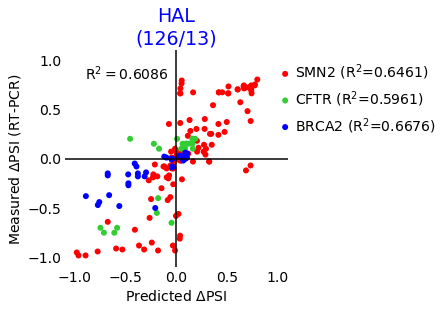

In [3]:
correct_num = get_accuracy(final_df.HAL_DPSI_PRED[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Correct']

incorrect_num = get_accuracy(final_df.HAL_DPSI_PRED[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Incorrect']

fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
colors = ['r','limegreen','b']
i=0
for gene in final_df.Gene.unique():
    cur_df = final_df[final_df.Gene==gene]
    r2 = scipy.stats.pearsonr(cur_df.HAL_DPSI_PRED,cur_df.DPSI)[0]**2
    ax.scatter(cur_df.HAL_DPSI_PRED,cur_df.DPSI,label=gene+' ($R^2$=%0.4f)' %r2,c=colors[i],edgecolor='None')
    i+=1
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
leg = ax.legend(scatterpoints=1,bbox_to_anchor=(1.72,1),fontsize=fsize,handletextpad=-0.3)
leg.get_frame().set_alpha(0)
ax.axis([-1.1,1.1,-1.1,1.1])
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Predicted $\Delta PSI$',fontsize=fsize)
ax.set_ylabel('Measured $\Delta PSI$ (RT-PCR)',fontsize=fsize)

r2 = scipy.stats.pearsonr(final_df.HAL_DPSI_PRED,
                           final_df.DPSI)[0]**2

ax.text(-0.9,0.8,'$R^2=%0.4f$'%r2,fontsize=fsize)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)
ax.set_title("HAL\n(%d/%d)" %(correct_num,incorrect_num), fontsize=fsize+5,color='blue')

In [4]:
fig.savefig('hal.png',dpi=400,bbox_inches='tight')

Text(0.5, 1.0, 'GTEx Donor\n(123/16)')

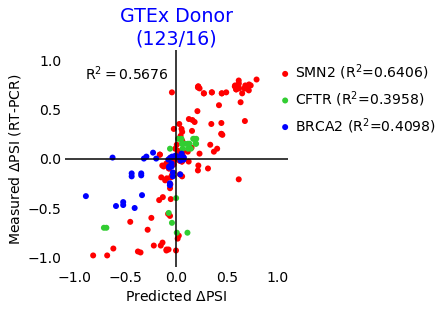

In [5]:
correct_num = get_accuracy(final_df.GTEX_DONOR_DPSI_PRED[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Correct']

incorrect_num = get_accuracy(final_df.GTEX_DONOR_DPSI_PRED[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Incorrect']

fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
colors = ['r','limegreen','b']
i=0
for gene in final_df.Gene.unique():
    cur_df = final_df[final_df.Gene==gene]
    r2 = scipy.stats.pearsonr(cur_df.GTEX_DONOR_DPSI_PRED,cur_df.DPSI)[0]**2
    ax.scatter(cur_df.GTEX_DONOR_DPSI_PRED,cur_df.DPSI,label=gene+' ($R^2$=%0.4f)' %r2,c=colors[i],edgecolor='None')
    i+=1
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
leg = ax.legend(scatterpoints=1,bbox_to_anchor=(1.72,1),fontsize=fsize,handletextpad=-0.3)
leg.get_frame().set_alpha(0)
ax.axis([-1.1,1.1,-1.1,1.1])
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Predicted $\Delta PSI$',fontsize=fsize)
ax.set_ylabel('Measured $\Delta PSI$ (RT-PCR)',fontsize=fsize)

r2 = scipy.stats.pearsonr(final_df.GTEX_DONOR_DPSI_PRED,
                           final_df.DPSI)[0]**2

ax.text(-0.9,0.8,'$R^2=%0.4f$'%r2,fontsize=fsize)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)
ax.set_title("GTEx Donor\n(%d/%d)" %(correct_num,incorrect_num), fontsize=fsize+5,color='blue')

In [6]:
fig.savefig('gtex_donor.png',dpi=400,bbox_inches='tight')

Text(0.5, 1.0, 'GTEx Acceptor\n(119/20)')

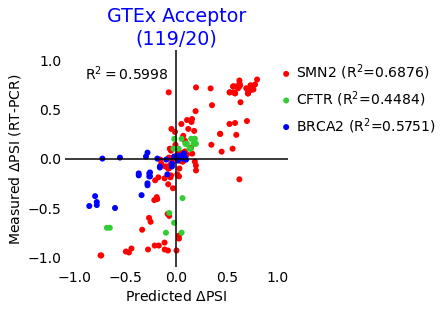

In [7]:
correct_num = get_accuracy(final_df.GTEX_ACCEPTOR_DPSI_PRED[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Correct']

incorrect_num = get_accuracy(final_df.GTEX_ACCEPTOR_DPSI_PRED[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Incorrect']

fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
colors = ['r','limegreen','b']
i=0
for gene in final_df.Gene.unique():
    cur_df = final_df[final_df.Gene==gene]
    r2 = scipy.stats.pearsonr(cur_df.GTEX_ACCEPTOR_DPSI_PRED,cur_df.DPSI)[0]**2
    ax.scatter(cur_df.GTEX_ACCEPTOR_DPSI_PRED,cur_df.DPSI,label=gene+' ($R^2$=%0.4f)' %r2,c=colors[i],edgecolor='None')
    i+=1
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
leg = ax.legend(scatterpoints=1,bbox_to_anchor=(1.72,1),fontsize=fsize,handletextpad=-0.3)
leg.get_frame().set_alpha(0)
ax.axis([-1.1,1.1,-1.1,1.1])
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Predicted $\Delta PSI$',fontsize=fsize)
ax.set_ylabel('Measured $\Delta PSI$ (RT-PCR)',fontsize=fsize)

r2 = scipy.stats.pearsonr(final_df.GTEX_ACCEPTOR_DPSI_PRED,
                           final_df.DPSI)[0]**2

ax.text(-0.9,0.8,'$R^2=%0.4f$'%r2,fontsize=fsize)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)
ax.set_title("GTEx Acceptor\n(%d/%d)" %(correct_num,incorrect_num), fontsize=fsize+5,color='blue')

In [8]:
fig.savefig('gtex_acceptor.png',dpi=400,bbox_inches='tight')

Text(0.5, 1.0, 'GTEx Joint\n(121/18)')

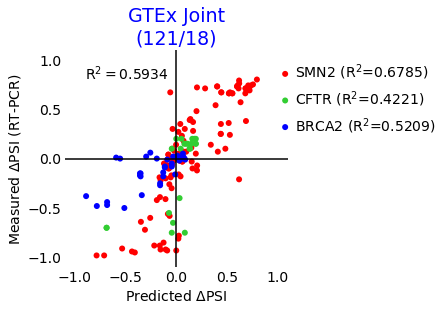

In [9]:
correct_num = get_accuracy(final_df.GTEX_JOINT_DPSI_PRED[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Correct']

incorrect_num = get_accuracy(final_df.GTEX_JOINT_DPSI_PRED[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Incorrect']

fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
colors = ['r','limegreen','b']
i=0
for gene in final_df.Gene.unique():
    cur_df = final_df[final_df.Gene==gene]
    r2 = scipy.stats.pearsonr(cur_df.GTEX_JOINT_DPSI_PRED,cur_df.DPSI)[0]**2
    ax.scatter(cur_df.GTEX_JOINT_DPSI_PRED,cur_df.DPSI,label=gene+' ($R^2$=%0.4f)' %r2,c=colors[i],edgecolor='None')
    i+=1
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
leg = ax.legend(scatterpoints=1,bbox_to_anchor=(1.72,1),fontsize=fsize,handletextpad=-0.3)
leg.get_frame().set_alpha(0)
ax.axis([-1.1,1.1,-1.1,1.1])
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Predicted $\Delta PSI$',fontsize=fsize)
ax.set_ylabel('Measured $\Delta PSI$ (RT-PCR)',fontsize=fsize)

r2 = scipy.stats.pearsonr(final_df.GTEX_JOINT_DPSI_PRED,
                           final_df.DPSI)[0]**2

ax.text(-0.9,0.8,'$R^2=%0.4f$'%r2,fontsize=fsize)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)
ax.set_title("GTEx Joint\n(%d/%d)" %(correct_num,incorrect_num), fontsize=fsize+5,color='blue')

In [10]:
fig.savefig('gtex_joint.png',dpi=400,bbox_inches='tight')

Text(0.5, 1.0, 'Our Donor\n(97/42)')

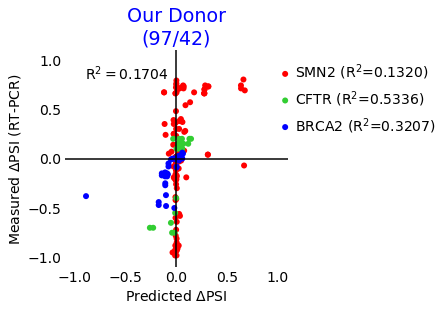

In [11]:
correct_num = get_accuracy(final_df.SP_400_DONOR_DPSI[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Correct']

incorrect_num = get_accuracy(final_df.SP_400_DONOR_DPSI[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Incorrect']

fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
colors = ['r','limegreen','b']
i=0
for gene in final_df.Gene.unique():
    cur_df = final_df[final_df.Gene==gene]
    r2 = scipy.stats.pearsonr(cur_df.SP_400_DONOR_DPSI,cur_df.DPSI)[0]**2
    ax.scatter(cur_df.SP_400_DONOR_DPSI,cur_df.DPSI,label=gene+' ($R^2$=%0.4f)' %r2,c=colors[i],edgecolor='None')
    i+=1
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
leg = ax.legend(scatterpoints=1,bbox_to_anchor=(1.72,1),fontsize=fsize,handletextpad=-0.3)
leg.get_frame().set_alpha(0)
ax.axis([-1.1,1.1,-1.1,1.1])
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Predicted $\Delta PSI$',fontsize=fsize)
ax.set_ylabel('Measured $\Delta PSI$ (RT-PCR)',fontsize=fsize)

r2 = scipy.stats.pearsonr(final_df.SP_400_DONOR_DPSI,
                           final_df.DPSI)[0]**2

ax.text(-0.9,0.8,'$R^2=%0.4f$'%r2,fontsize=fsize)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)
ax.set_title("Our Donor\n(%d/%d)" %(correct_num,incorrect_num), fontsize=fsize+5,color='blue')

In [12]:
fig.savefig('donor_our.png',dpi=400,bbox_inches='tight')

Text(0.5, 1.0, 'Our Acceptor\n(105/34)')

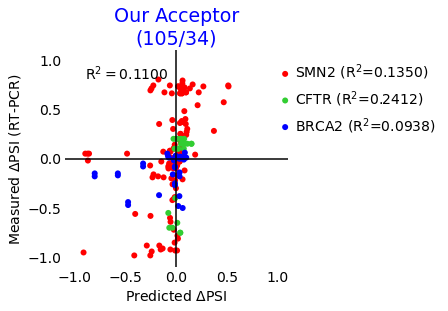

In [13]:
correct_num = get_accuracy(final_df.SP_400_ACCEPTOR_DPSI[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Correct']

incorrect_num = get_accuracy(final_df.SP_400_ACCEPTOR_DPSI[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Incorrect']

fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
colors = ['r','limegreen','b']
i=0
for gene in final_df.Gene.unique():
    cur_df = final_df[final_df.Gene==gene]
    r2 = scipy.stats.pearsonr(cur_df.SP_400_ACCEPTOR_DPSI,cur_df.DPSI)[0]**2
    ax.scatter(cur_df.SP_400_ACCEPTOR_DPSI,cur_df.DPSI,label=gene+' ($R^2$=%0.4f)' %r2,c=colors[i],edgecolor='None')
    i+=1
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
leg = ax.legend(scatterpoints=1,bbox_to_anchor=(1.72,1),fontsize=fsize,handletextpad=-0.3)
leg.get_frame().set_alpha(0)
ax.axis([-1.1,1.1,-1.1,1.1])
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Predicted $\Delta PSI$',fontsize=fsize)
ax.set_ylabel('Measured $\Delta PSI$ (RT-PCR)',fontsize=fsize)

r2 = scipy.stats.pearsonr(final_df.SP_400_ACCEPTOR_DPSI,
                           final_df.DPSI)[0]**2

ax.text(-0.9,0.8,'$R^2=%0.4f$'%r2,fontsize=fsize)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)
ax.set_title("Our Acceptor\n(%d/%d)" %(correct_num,incorrect_num), fontsize=fsize+5,color='blue')

In [14]:
fig.savefig('acceptor_our.png',dpi=400,bbox_inches='tight')

Text(0.5, 1.0, 'Our Joint\n(112/27)')

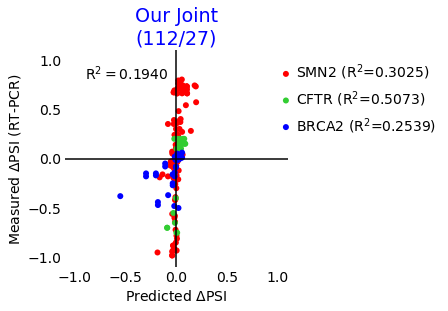

In [15]:
correct_num = get_accuracy(final_df.SP_400_JOINT_DPSI[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Correct']

incorrect_num = get_accuracy(final_df.SP_400_JOINT_DPSI[abs(final_df.DPSI)>0.05],
                           final_df.DPSI[abs(final_df.DPSI)>0.05])['Incorrect']

fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
colors = ['r','limegreen','b']
i=0
for gene in final_df.Gene.unique():
    cur_df = final_df[final_df.Gene==gene]
    r2 = scipy.stats.pearsonr(cur_df.SP_400_JOINT_DPSI,cur_df.DPSI)[0]**2
    ax.scatter(cur_df.SP_400_JOINT_DPSI,cur_df.DPSI,label=gene+' ($R^2$=%0.4f)' %r2,c=colors[i],edgecolor='None')
    i+=1
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
leg = ax.legend(scatterpoints=1,bbox_to_anchor=(1.72,1),fontsize=fsize,handletextpad=-0.3)
leg.get_frame().set_alpha(0)
ax.axis([-1.1,1.1,-1.1,1.1])
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Predicted $\Delta PSI$',fontsize=fsize)
ax.set_ylabel('Measured $\Delta PSI$ (RT-PCR)',fontsize=fsize)

r2 = scipy.stats.pearsonr(final_df.SP_400_JOINT_DPSI,
                           final_df.DPSI)[0]**2

ax.text(-0.9,0.8,'$R^2=%0.4f$'%r2,fontsize=fsize)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)
ax.set_title("Our Joint\n(%d/%d)" %(correct_num,incorrect_num), fontsize=fsize+5,color='blue')

In [16]:
fig.savefig('joint_our.png',dpi=400,bbox_inches='tight')